In [14]:
#from halving import GridSuccessiveHalving
import numpy as np

import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits, fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

from joblib import Memory

mem = Memory(location='/tmp')

# get some data
digits = load_digits()
X, y = digits.data, digits.target
@mem.cache
def bla():
    mnist = fetch_openml("mnist_784")
    return mnist.data, mnist.target

# X, y = bla()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}



# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


In [27]:
from sklearn.svm import SVC
param_grid = {'gamma': np.logspace(-3, 3, 7), 'C': np.logspace(-3, 3, 7)}
param_grid

{'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [38]:
tot_time = []
results = []
train_sizes = [0.1, 0.2, 0.4, 0.8]
for train_size in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X / 16., y, stratify=y, random_state=1, train_size=.80)
    grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, iid=False)
    start = time.time()
    grid_search.fit(X_train, y_train)
    tot_time.append(time.time() - start)
    res = pd.DataFrame(grid_search.cv_results_).pivot(index='param_C', columns='param_gamma', values='mean_test_score')
    results.append(res)

/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


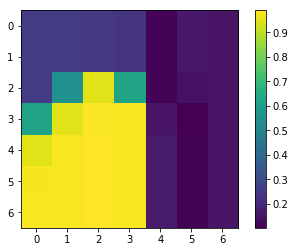

In [37]:
fig, axes = plt.subplots(1, 4)
for i, ax in enumerate(axes):
    ax.imshow(results[i].values)
    ax.set_title("Size: {}\% time: {}".format(train_sizes[i] * 100, tot_time[i]))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_features=2).fit(digits.data, digits.target)
tree

In [20]:
param_grid = {'max_depth': , 'max_features': [2, 4, 8, 16, 32, 64]}


param_gamma,0.001,0.01,0.1,1.0,10.0,100.0
param_C,,,,,,
0.001,0.837368,0.827368,0.837895,0.674211,0.293684,0.900000
0.010,0.837368,0.827368,0.837895,0.674211,0.293684,0.900000
0.100,0.837368,0.827368,0.837895,0.674211,0.293684,0.900000
1.000,0.837368,0.827368,0.878947,0.776316,0.313684,0.838947
10.000,0.837368,0.898947,0.899474,0.807368,0.333684,0.838947
100.000,0.898947,0.919474,0.899474,0.807368,0.333684,0.838947


In [8]:
from  civismlext import HyperbandSearchCV

In [13]:
hp = HyperbandSearchCV(clf, param_distributions=param_dist, cost_parameter_max={'n_estimators': 20}, cv=5, verbose=10)

In [14]:
hp.fit(X_train, y_train)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2, score=(train=1.000, test=0.766), total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2, score=(train=1.000, test=0.757), total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2, score=(train=1.000, test=0.758), total=   0.6s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2, score=(train=1.000, test=0.750), total=   0.7s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.5s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=5, min_samples_split=2, n_estimators=2, score=(train=1.000, test=0.753), total=   0.7s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2, score=(train=0.339, test=0.344), total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.9s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2, score=(train=0.277, test=0.277), total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.3s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2, score=(train=0.366, test=0.366), total=   0.5s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.0s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2, score=(train=0.359, test=0.360), total=   0.3s
[CV] bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.5s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=3, max_features=2, min_samples_split=6, n_estimators=2, score=(train=0.387, test=0.383), total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=3, min_samples_split=4, n_estimators=2 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=3, min_samples_split=4, n_estimators=2, score=(train=0.364, test=0.358), total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=3, min_samples_split=4, n_estimators=2 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=3, min_samples_split=4, n_estimators=2, score=(train=0.368, test=0.371), total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=3, min_samples_split=4, n_estimators=2 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=3, min_samples_split=4, n_estimators=2, score=(train=0.421, test=0.420), total=   0.3s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=3, min_samples_split=

[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=3, min_samples_split=5, n_estimators=6, score=(train=1.000, test=0.905), total=   0.9s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=3, min_samples_split=5, n_estimators=6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=3, min_samples_split=5, n_estimators=6, score=(train=1.000, test=0.905), total=   0.8s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=3, min_samples_split=5, n_estimators=6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=3, min_samples_split=5, n_estimators=6, score=(train=1.000, test=0.895), total=   0.8s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=3, min_samples_split=5, n_estimators=6 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=3, min_samples_split=5, n_estimators=6, score=(train=1.000, test=0.899), total=   0.8s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=3, min_samples_split=5, n_estimators=6 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=3, min_samples_split=5, n_estimators=6, score=(train=1.000, test=0.893), total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6, score=(train=0.985, test=0.914), total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.0s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6, score=(train=0.986, test=0.916), total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.3s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6, score=(train=0.984, test=0.915), total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.5s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6, score=(train=0.986, test=0.914), total=   1.0s
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   10.8s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6, score=(train=0.986, test=0.908), total=   1.0s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6, score=(train=0.999, test=0.931), total=   2.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6, score=(train=0.999, test=0.928), total=   2.4s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=6, score=(train=0.999, test=0.922), total=   1.7s
[CV] bootstrap=False, criterion=gini, max_depth=None,

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   43.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=18, score=(train=1.000, test=0.957), total=   4.2s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=18 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=18, score=(train=1.000, test=0.957), total=   6.8s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=18 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=18, score=(train=1.000, test=0.954), total=   6.5s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=18 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.9s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=18, score=(train=1.000, test=0.952), total=   5.7s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=18 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.3s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=7, n_estimators=18, score=(train=1.000, test=0.953), total=   6.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.8s finished


HyperbandSearchCV(cost_parameter_max={'n_estimators': 20},
                  cost_parameter_min=None, cv=5, error_score='raise',
                  estimator=RandomForestClassifier(bootstrap=True,
                                                   class_weight=None,
                                                   criterion='gini',
               ...': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f39c402a128>,
                                       'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f399467d5c0>},
                  pre_dispatch='2*n_jobs', random_state=None, refit=True,
                  return_train_score=True, scoring=None, verbose=10)

In [22]:
sh = GridSuccessiveHalving(clf, param_grid=param_grid, cv=5, random_state=0)
start = time.time()
sh.fit(X_train, y_train)

print("Successive Halving took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(sh.cv_results_['params'])))
report(sh.cv_results_)

7
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=2 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=2, score=(train=0.846, test=0.346), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=2 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=2, score=(train=0.805, test=0.455), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=2 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=2, score=(train=0.771, test=0.381), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=2 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=2, score=(train=0.826, test=0.444), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=10, score=(train=0.756, test=0.385), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=10, score=(train=0.768, test=0.455), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=10, score=(train=0.747, test=0.524), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=10, score=(train=0.744, test=0.389), total=   0.0s
[CV] bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=10 
[CV]  bootstrap=True, criterion=gini, max_depth=3, max_features=1, min_samples_split=10, score=(train=0.

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.628), total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.744), total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.711), total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.727), total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_de

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.744), total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.684), total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=1, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=1, min_samples_split=3, score=(train=1.000, test=0.636), total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=1, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=1, min_samples_split=3, score=(train=1.000, test=0.659), total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=1, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=1, min_samples_split=2, score=(train=1.000, test=0.711), total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=1, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=1, min_samples_split=2, score=(train=1.000, test=0.790), total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=1, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=1, min_samples_split=2, score=(train=1.000, test=0.713), total=   0.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.805), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.812), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.795), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.827), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.787), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=3, min_samples_split=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=3, min_samples_split=10, score=(train=0.997, test=0.805), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=3, min_samples_split=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=3, min_samples_split=10, score=(train=0.997, test=0.824), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=3, min_samples_split=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=3, min_samples_split=10, score=(train=1.000, test=0.759), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=3, min_samples_split=10 
[CV]  bootstrap=False, criterion=entropy, max_de

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.821), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.851), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.896), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.846), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.795), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.863), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.798), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.866), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=2, score=(train=1.000, test=0.877), total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.813), total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.0s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.845), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.845), total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.884), total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.858), total=   0.0s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10,

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.877), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.873), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.999, test=0.876), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.999, test=0.883), total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.891), total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.874), total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.867), total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.999, test=0.910), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.869), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.861), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.860), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.890), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.876), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.999, test=0.881), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.998, test=0.885), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.916), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.901), total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.897), total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.879), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.999, test=0.879), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.918), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.999, test=0.887), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.917), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.883), total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.881), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.906), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3, score=(train=1.000, test=0.905), total=   0.1s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=3 
[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.903), total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.912), total=   0.3s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.999, test=0.887), total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.902), total=   0.2s
[CV] bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=gini, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.998, test=0.906), total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.908), total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.8s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.908), total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.999, test=0.895), total=   0.5s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.7s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=1.000, test=0.898), total=   0.4s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.1s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=10, score=(train=0.999, test=0.899), total=   0.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished


Successive Halving took 36.21 seconds for 145 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.902 (std: 0.008)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.902 (std: 0.006)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.896 (std: 0.018)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 10}



In [23]:
sh.score(X_test, y_test)

0.9594285714285714

In [24]:
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, verbose=10, random_state=0)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.936, total=   2.1s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.934, total=   1.9s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.928, total=   1.7s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.933, total=   1.7s
[CV] bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.5s remaining:    0.0s


[CV]  bootstrap=True, criterion=entropy, max_depth=None, max_features=1, min_samples_split=5, score=0.931, total=   1.9s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.958, total=   6.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.4s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.956, total=   6.1s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.5s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.955, total=   6.0s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   27.6s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.956, total=   6.4s
[CV] bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.0s remaining:    0.0s


[CV]  bootstrap=False, criterion=entropy, max_depth=None, max_features=10, min_samples_split=5, score=0.954, total=   6.0s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8, score=0.704, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8, score=0.710, total=   1.4s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8, score=0.730, total=   1.1s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8 
[CV]  bootstrap=False, criterion=gini, max_depth=3, max_features=8, min_samples_split=8, score=0.690, total=   1.2s
[CV] bootstrap=False, criterion=gini, max_depth=3, max_featur

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.0min finished


RandomizedSearchCV took 249.71 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.957 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.956 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_split': 6}

Model with rank: 3
Mean validation score: 0.956 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 5}



In [32]:
import pandas as pd
#.groupby("params").plot(x="iter", y="mean_test_score")

In [25]:
random_search.score(X_test, y_test)

0.9583428571428572

In [39]:
res = pd.DataFrame(sh.cv_results_)
res['params_str'] = res.params.apply(str)
reshape = res.pivot(index='iter', columns='params_str', values='mean_test_score')
reshape.plot(legend=False, alpha=.4, c='k')

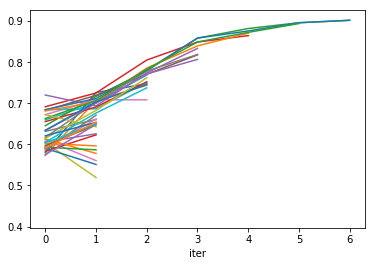

In [44]:
import matplotlib.pyplot as plt
res.groupby("params_str").plot('iter', 'mean_test_score', ax=plt.gca(), legend=False);

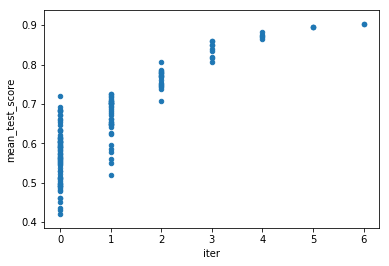

In [38]:
%matplotlib inline
res.plot('iter', 'mean_test_score', kind='scatter')

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X / 255., y, stratify=y, random_state=0, train_size=1000)


/home/andy/checkout/scikit-learn/sklearn/model_selection/_split.py:2184: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
from sklearn.svm import SVC
param_grid = {'gamma': np.logspace(-3, 2, 6), 'C': np.logspace(-3, 2, 6)}
param_grid

{'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])}

In [70]:
# run grid search
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, iid=False, verbose=10)
start = time.time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ C=0.001, gamma=0.001, score=0.113, total=   1.4s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.113, total=   1.5s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.114, total=   1.5s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.4s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.111, total=   1.4s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s


[CV] ................ C=0.001, gamma=0.001, score=0.113, total=   1.5s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.3s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.113, total=   1.3s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.7s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.113, total=   1.4s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   10.0s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.114, total=   1.5s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.5s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.111, total=   1.4s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.9s remaining:    0.0s


[CV] ................. C=0.001, gamma=0.01, score=0.113, total=   1.6s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.113, total=   1.6s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.113, total=   1.5s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.114, total=   1.6s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.111, total=   1.4s
[CV] C=0.001, gamma=0.1 ..............................................
[CV] .................. C=0.001, gamma=0.1, score=0.113, total=   1.6s
[CV] C=0.001, gamma=1.0 ..............................................
[CV] .................. C=0.001, gamma=1.0, score=0.113, total=   1.5s
[CV] C=0.001, gamma=1.0 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  4.1min finished


GridSearchCV took 244.53 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.913 (std: 0.015)
Parameters: {'C': 10.0, 'gamma': 0.01}

Model with rank: 1
Mean validation score: 0.913 (std: 0.015)
Parameters: {'C': 100.0, 'gamma': 0.01}

Model with rank: 3
Mean validation score: 0.888 (std: 0.017)
Parameters: {'C': 1.0, 'gamma': 0.01}



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X / 255., y, stratify=y, random_state=0)

sh = GridSuccessiveHalving(SVC(), param_grid=param_grid, cv=5, random_state=0, verbose=10)
start = time.time()
sh.fit(X_train, y_train)

print("Successive Halving took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(sh.cv_results_['params'])))
report(sh.cv_results_)

6
n_samples_iter: 1458
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.125), total=   3.1s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.123), total=   2.7s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.6s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.123), total=   2.8s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.124), total=   2.8s
[CV] C=0.001, gamma=0.001 ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.1s remaining:    0.0s


[CV]  C=0.001, gamma=0.001, score=(train=0.124, test=0.125), total=   2.8s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.4s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.125), total=   2.8s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.6s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.123), total=   2.7s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   29.7s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.123), total=   2.8s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   33.9s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.124), total=   2.8s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   38.1s remaining:    0.0s


[CV]  C=0.001, gamma=0.01, score=(train=0.124, test=0.125), total=   2.8s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.125), total=   2.7s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.123), total=   2.7s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.123), total=   2.7s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.124), total=   2.8s
[CV] C=0.001, gamma=0.1 ..............................................
[CV]  C=0.001, gamma=0.1, score=(train=0.124, test=0.125), total=   2.8s
[CV] C=0.001, gamma=1.0 ..............................................
[CV]  C=0.001, gamma=1.0, score=(train=0.124, test=0.125), total=   2.9s
[CV] C=0.001, gamma=1.0 ......................................

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 996.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.952), total=   3.3s
[CV] C=100.0, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.954), total=   3.4s
[CV] C=100.0, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.0s remaining:    0.0s


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.940), total=   3.3s
[CV] C=100.0, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.4s remaining:    0.0s


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.928), total=   3.4s
[CV] C=100.0, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.2s remaining:    0.0s


[CV]  C=100.0, gamma=0.01, score=(train=1.000, test=0.926), total=   3.5s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.0s remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.952), total=   3.8s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   41.8s remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.954), total=   5.7s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   52.5s remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.940), total=   5.5s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.928), total=   6.7s
[CV] C=10.0, gamma=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[CV]  C=10.0, gamma=0.01, score=(train=1.000, test=0.926), total=   6.4s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.972, test=0.940), total=   6.8s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.970, test=0.933), total=   8.0s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.973, test=0.937), total=   8.6s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.969, test=0.929), total=   7.5s
[CV] C=1.0, gamma=0.01 ...............................................
[CV]  C=1.0, gamma=0.01, score=(train=0.971, test=0.903), total=   7.9s
[CV] C=10.0, gamma=0.001 .............................................
[CV]  C=10.0, gamma=0.001, score=(train=0.954, test=0.920), total=   8.0s
[CV] C=10.0, gamma=0.001 ..........................................

In [75]:
grid_search.score(X_test, y_test)


0.9194666666666667

In [10]:
sh.score(X_test, y_test)

0.9187536231884058

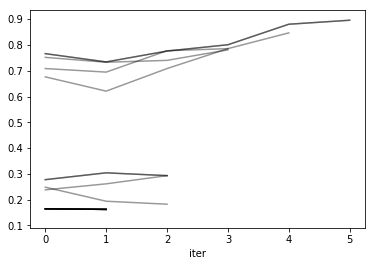

In [5]:
%matplotlib inline
import pandas as pd

res = pd.DataFrame(sh.cv_results_)
res['params_str'] = res.params.apply(str)
reshape = res.pivot(index='iter', columns='params_str', values='mean_test_score')
reshape.plot(legend=False, alpha=.4, c='k')

In [6]:
reshape

params_str,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1.0}","{'C': 0.001, 'gamma': 10.0}","{'C': 0.001, 'gamma': 100.0}","{'C': 0.01, 'gamma': 0.001}","{'C': 0.01, 'gamma': 0.01}","{'C': 0.01, 'gamma': 0.1}","{'C': 0.01, 'gamma': 1.0}",...,"{'C': 10.0, 'gamma': 0.1}","{'C': 10.0, 'gamma': 1.0}","{'C': 10.0, 'gamma': 10.0}","{'C': 10.0, 'gamma': 100.0}","{'C': 100.0, 'gamma': 0.001}","{'C': 100.0, 'gamma': 0.01}","{'C': 100.0, 'gamma': 0.1}","{'C': 100.0, 'gamma': 1.0}","{'C': 100.0, 'gamma': 10.0}","{'C': 100.0, 'gamma': 100.0}"
iter,,,,,,,,,,,,,,,,,,,,,
0,0.164668,0.164668,0.129374,0.129374,0.164668,0.141138,0.164668,0.164668,0.129374,0.129374,...,0.277687,0.129374,0.164668,0.141138,0.751719,0.766145,0.277687,0.129374,0.164668,0.141138
1,0.162487,NaN,NaN,NaN,NaN,NaN,0.162487,0.162487,NaN,NaN,...,0.304140,NaN,0.162487,NaN,0.732745,0.733937,0.304140,NaN,0.162487,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.293254,NaN,NaN,NaN,0.740079,0.776190,0.293254,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.780840,0.800602,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.880104,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.895587,NaN,NaN,NaN,NaN


In [7]:
bla = res.groupby('params_str')['mean_test_score'].median()

In [8]:
new = res.drop_duplicates(subset='params_str', keep='last')[['param_gamma', 'param_C', 'mean_test_score']]

In [9]:
new.pivot(index='param_C', columns='param_gamma')

mean_test_score                                                  
param_gamma         0.001     0.010     0.100     1.000     10.000    100.000
param_C                                                                      
0.001              0.162487  0.164668  0.129374  0.129374  0.164668  0.141138
0.010              0.162487  0.162487  0.129374  0.129374  0.162487  0.141138
0.100              0.162487  0.164668  0.129374  0.129374  0.162487  0.141138
1.000              0.182540  0.846617  0.293254  0.129374  0.162487  0.141138
10.000             0.785551  0.895587  0.293254  0.129374  0.162487  0.141138
100.000            0.780840  0.895587  0.293254  0.129374  0.162487  0.141138

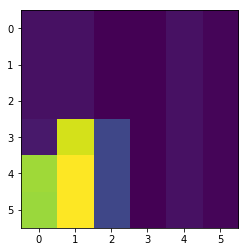

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(new.pivot(index='param_C', columns='param_gamma'))

In [10]:
res.drop_duplicates(subset='params_str', keep='last')[['param_gamma', 'param_C', 'iter']].pivot(index='param_C', columns='param_gamma')

iter                                        
param_gamma 0.001   0.010   0.100   1.000   10.000  100.000
param_C                                                    
0.001             1       0       0       0       0       0
0.010             1       1       0       0       1       0
0.100             1       0       0       0       1       0
1.000             2       4       2       0       1       0
10.000            3       5       2       0       1       0
100.000           3       5       2       0       1       0

In [3]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [5]:
start = time.time()
LogisticRegressionCV(cv=5, multi_class='multinomial', solver='sag').fit(X_train, y_train)
print(time.time() - start)

/home/andy/checkout/scikit-learn/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


KeyboardInterrupt: 